Electricity data. 7 features. 2 classes.
100 batches of 261 instances



METHOD: Static knn as classifier
Execution time:  1.4005792390485026
Average MCC:  0.377463942467
Average micro-F1: 0.7076
Average Accuracy:  70.7852
Standard Deviation:  10.8687389775
Variance:  118.12948696


C:\Users\raul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


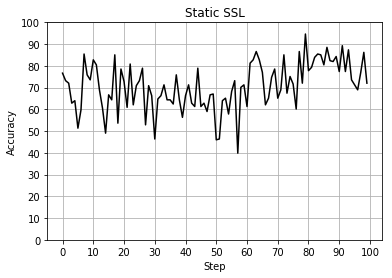

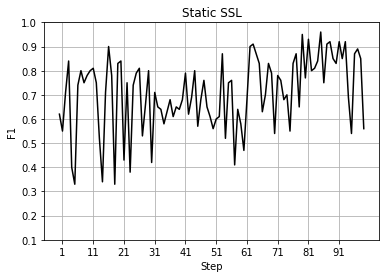




METHOD: Sliding knn as classifier
Execution time:  0.16253774811832233
Average MCC:  0.0157029110337
Average micro-F1: 0.5891
Average Accuracy:  58.9654
Standard Deviation:  9.99732838512
Variance:  99.94657484


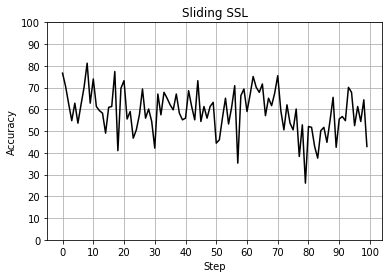

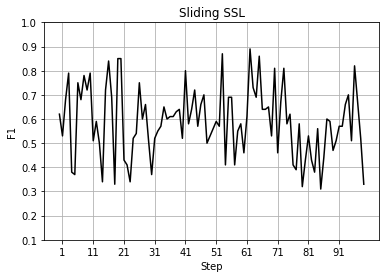




METHOD: Incremental knn as classifier
Execution time:  10.114051860502233
Average MCC:  0.384469081955
Average micro-F1: 0.7130999999999997
Average Accuracy:  71.0807
Standard Deviation:  11.6287708942
Variance:  135.22831251


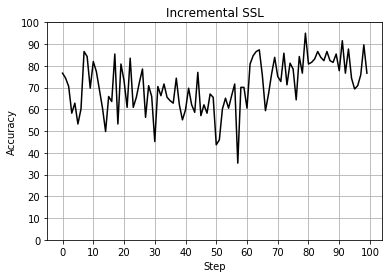

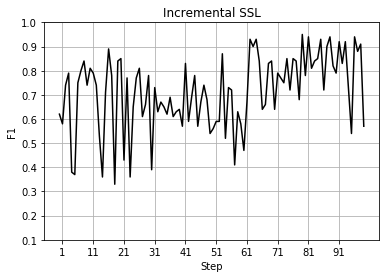




METHOD: knn as classifier and kde as core support extraction with cutting data method
Execution time:  2.822567251304889
Average MCC:  0.490464874488
Average micro-F1: 0.7504000000000001
Average Accuracy:  73.8808
Standard Deviation:  10.7350192063
Variance:  115.24063736


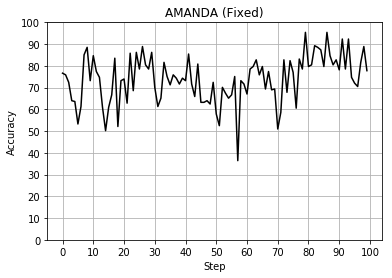

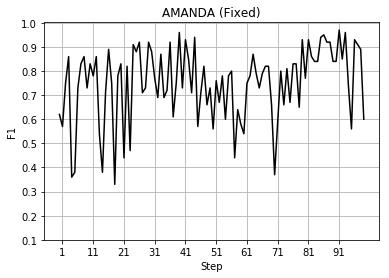




METHOD: knn as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  1276.0754045823965
Average MCC:  0.334982118609
Average micro-F1: 0.6592999999999999
Average Accuracy:  65.5592
Standard Deviation:  14.4936989537
Variance:  210.06730936


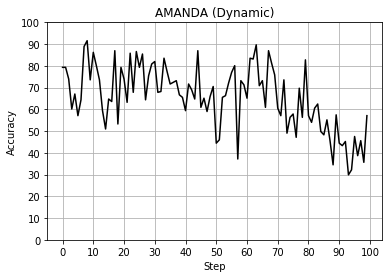

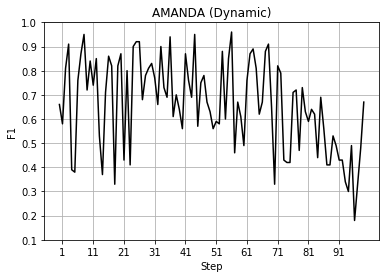




METHOD: None as classifier and GMM with BIC and Mahalanobis as core support extraction
gmmWithBIC: Error to choose the best GMM model
'NoneType' object has no attribute 'precisions_'
Method: Level IW
Execution time:  1276.0754045823965
Average MCC:  -0.00702351436729
Average micro-F1: 0.5548
Average Accuracy:  67.366116
Standard Deviation:  14.1293651683
Variance:  199.638960059


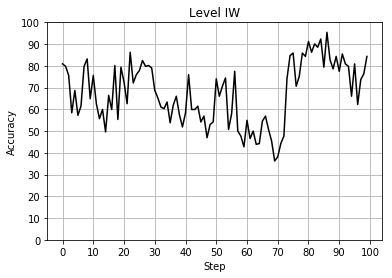

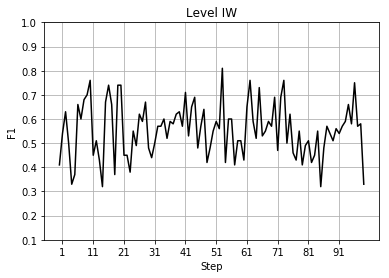

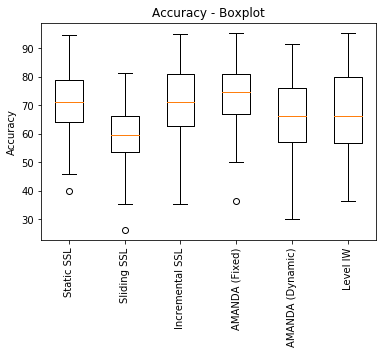

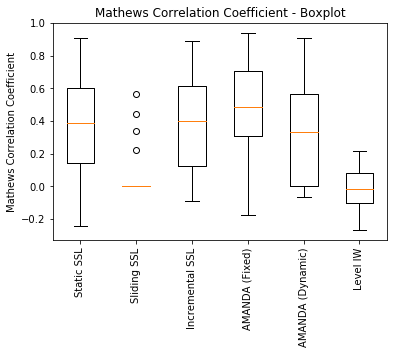

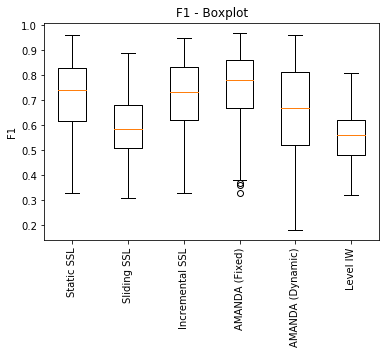

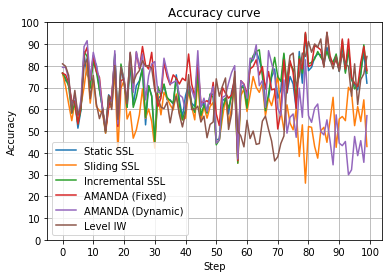

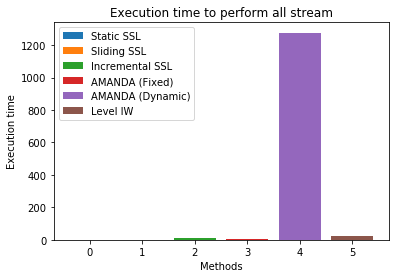

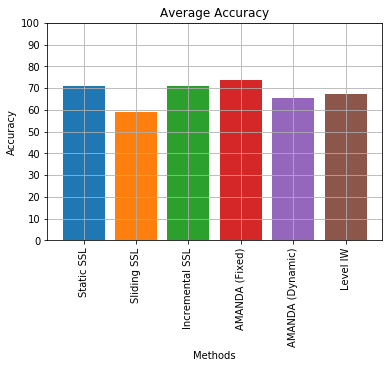

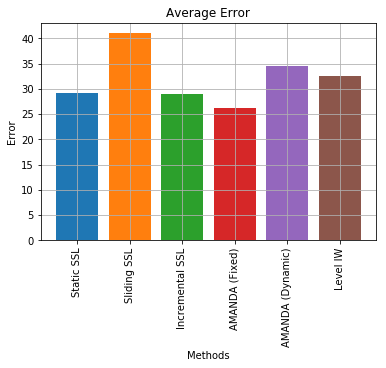

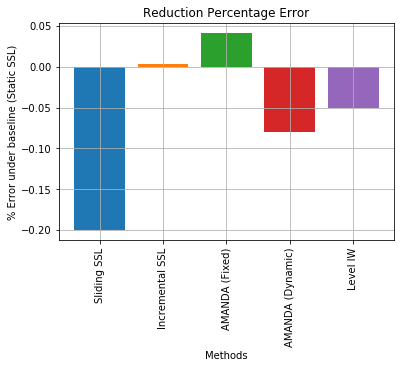

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'knn' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = True
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadElecData(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 6, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 6, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 6, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 6, 0.6, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 12, None, "kde", sslClassifier)

    # COMPOSE GMM (Python version)
    experiments[5] = Experiment(compose_gmm_version, 6)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'elec2', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()